# Анализ постов Instagram. Часть 3 – Анализ пересечения хештегов

Третья часть серии туториалов, посвященных анализу записей и, в частности, хештегов Instagram. Описанные методы могут использоваться для количественного исследования других социальных сетей при условии использлования системы хештегов.

В качестве набора данных используется датасет, выгруженный в период с апреля по май 2020, по выявленному набору хештегов на тему акции «Бессметрный полк».    

## Анализ пересечения хештегов

На предыдущем шаге мы выделили теги в отдельную колонку `tags`. Далее, сделаем обработку полученного массива и поймем, как выделенные теги пересекаются друг с другом: проведем анализ частотности наличия пары тегов в одном посте.  

In [1]:
import numpy as np
import pandas as pd

In [2]:
filename = 'my_polk_demo__2-res'

Для считывания данных создадим вспомогательный атрибут `tag_convertor`, указывающий на способ обработки входящей колонки `tags`.

In [3]:
tag_convertor = {'tags': lambda x: x.strip('[]').replace('\'', '').split(', ') if len(x) > 0 else np.nan}

In [4]:
df_ = pd.read_csv(f"data/{filename}.csv", low_memory=False, index_col=0, converters=tag_convertor)

In [5]:
df_.head()

,id,owner_id,shortcode,post_url,display_url,published,caption,likes_count,comments_count,is_video,video_view_count,tags
0,2290507756257899980,3.385755e+10,B_JhKsvB3XM,https://www.instagram.com/p/B_JhKsvB3XM/,https://instagram.fhel5-1.fna.fbcdn.net/v/t51....,2020-04-19 04:17:04+00,#75летпобеды #победа75 #мыпомним #великаяпо...,41,0,False,NaN,"[75летпобеды, победа75, мыпомним, великаяпобед..."
1,2283363816720116246,3.272358e+10,B-wI0sklSoW,https://www.instagram.com/p/B-wI0sklSoW/,https://instagram.fhel5-1.fna.fbcdn.net/v/t51....,2020-04-09 07:43:20+00,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,9,0,False,NaN,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
2,2283364236083479227,3.272358e+10,B-wI6zIlkK7,https://www.instagram.com/p/B-wI6zIlkK7/,https://instagram.fhel5-1.fna.fbcdn.net/v/t51....,2020-04-09 07:44:10+00,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,10,0,False,NaN,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
3,2283370574013238191,2.753139e+09,B-wKXByo4uv,https://www.instagram.com/p/B-wKXByo4uv/,https://instagram.fhel5-1.fna.fbcdn.net/v/t51....,2020-04-09 07:56:45+00,Вышел в свет новый номер газеты «Каширские изв...,94,1,False,NaN,"[каширскоеиа, кашира, подмосковье, вкурсе2020,..."
4,2283365441896285449,6.646030e+09,B-wJMWIoYUJ,https://www.instagram.com/p/B-wJMWIoYUJ/,https://instagram.fhel5-1.fna.fbcdn.net/v/t51....,2020-04-09 07:57:34+00,Вот что получилось у меня после первых прислан...,8,0,True,41.0,"[вокальнаястудиядебют, флешмоб2020, бессмертны..."


### Предобработка 
Выделим только те данные, с которыми будем работать, а именно `id`, `tags`. Удалим пустые строки `caption` и `tags`.

In [6]:
df = df_.dropna(subset=['caption', 'tags'])
df = df[['id', 'post_url', 'caption', 'tags']]
df.head()

,id,post_url,caption,tags
0,2290507756257899980,https://www.instagram.com/p/B_JhKsvB3XM/,#75летпобеды #победа75 #мыпомним #великаяпо...,"[75летпобеды, победа75, мыпомним, великаяпобед..."
1,2283363816720116246,https://www.instagram.com/p/B-wI0sklSoW/,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
2,2283364236083479227,https://www.instagram.com/p/B-wI6zIlkK7/,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
3,2283370574013238191,https://www.instagram.com/p/B-wKXByo4uv/,Вышел в свет новый номер газеты «Каширские изв...,"[каширскоеиа, кашира, подмосковье, вкурсе2020,..."
4,2283365441896285449,https://www.instagram.com/p/B-wJMWIoYUJ/,Вот что получилось у меня после первых прислан...,"[вокальнаястудиядебют, флешмоб2020, бессмертны..."


Соберем все теги в один список `flattened_tags_df` и эмпирически подберем минимальное число упоминаний тегов, тем самым выберем самые популярные среди них.

In [7]:
flattened_tags = pd.Series([tag for tag_list in df.tags for tag in tag_list])

In [8]:
flattened_tags_counts = flattened_tags.value_counts()

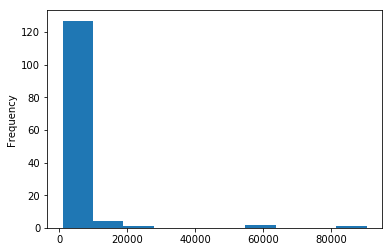

In [9]:
flattened_tags_counts.loc[flattened_tags_counts > 1000].plot(kind='hist')

Отсечение в > 1000 упоминаний не подходит, так как таких тегов много (больше 100). 

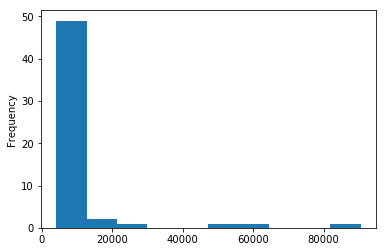

In [10]:
flattened_tags_counts.loc[flattened_tags_counts > 4000].plot(kind='hist')

4000 – выглядит более оптимальным числом, так как дает на выходе около 50 тегов. Создадим переменную `min_count` со значением 4000.

In [11]:
min_count = 4000

In [12]:
top_tags_set = set(flattened_tags_counts.loc[flattened_tags_counts > min_count].index)

In [13]:
len(top_tags_set)

55

55 – количество тегов, упоминаемых более 4000 раз.

In [14]:
top_tags_set

{'75летпобеды',
 '9мая',
 '9мая2019',
 'ауе',
 'ауежизньворам',
 'базарунет',
 'бандит',
 'бандиты',
 'бесмертныйполк',
 'беспридел',
 'бессмертный',
 'бессмертный_полк',
 'бессмертныйполк',
 'бессмертныйполк2017',
 'бессмертныйполк2018',
 'бессмертныйполк2019',
 'бессмертныйполк2020',
 'бессмертныйполконлайн',
 'бессмертныйполкроссии',
 'бессмертныйполктатарстан',
 'блатной',
 'братзабрата',
 'великаяотечественнаявойна',
 'великаяпобеда',
 'ветераны',
 'вов',
 'волки',
 'вор',
 'ворывзаконе',
 'гангстеры',
 'ганджа',
 'гиопика',
 'деньпобеды',
 'деньпобеды2019',
 'криминал',
 'марихуана',
 'мафия',
 'москва',
 'мыпомним',
 'наркотики',
 'память',
 'парад',
 'парадпобеды',
 'победа',
 'помним',
 'праздник',
 'россия',
 'сднемпобеды',
 'скемтытам',
 'спасибодедузапобеду',
 'спасибозапобеду',
 'уроди',
 'хулиганы',
 'хулиганы2',
 'япомнюягоржусь'}

В множество тегов попали такие слова, как: `#ауе`, `#ауежизньворам`, `#базарунет`, `#бандит` и другие «блатные» понятия. Пока что оставим их, посмотрим как они коррелируют с тематическими тегами. 

В рабочий датасет `df` добавим колонку `top_tags`, в которой укажем теги из множества `top_tags_set` для каждого поста.

In [15]:
df['top_tags'] = df.tags.apply(lambda x: [tag for tag in x if tag in top_tags_set]); df.head()

,id,post_url,caption,tags,top_tags
0,2290507756257899980,https://www.instagram.com/p/B_JhKsvB3XM/,#75летпобеды #победа75 #мыпомним #великаяпо...,"[75летпобеды, победа75, мыпомним, великаяпобед...","[75летпобеды, мыпомним, великаяпобеда, бессмер..."
1,2283363816720116246,https://www.instagram.com/p/B-wI0sklSoW/,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный...","[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
2,2283364236083479227,https://www.instagram.com/p/B-wI6zIlkK7/,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный...","[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
3,2283370574013238191,https://www.instagram.com/p/B-wKXByo4uv/,Вышел в свет новый номер газеты «Каширские изв...,"[каширскоеиа, кашира, подмосковье, вкурсе2020,...",[бессмертныйполк]
4,2283365441896285449,https://www.instagram.com/p/B-wJMWIoYUJ/,Вот что получилось у меня после первых прислан...,"[вокальнаястудиядебют, флешмоб2020, бессмертны...",[бессмертныйполк]


Выделим только те посты, в которых есть топовые теги.

In [16]:
df_top_tags = df.loc[df.top_tags.apply(lambda x: x !=[])]

In [17]:
df_top_tags.shape[0] / df.shape[0]

0.9473274344273396

~95% постов содержат в себе топовые теги.

### Создание матрицы пересечения 
Создадим новый датафрейм `tag_vector_df`, в который запишем топовые теги.

In [18]:
tag_vector_df = df_top_tags.loc[:, ['top_tags']]; tag_vector_df.head()

,top_tags
0,"[75летпобеды, мыпомним, великаяпобеда, бессмер..."
1,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
2,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
3,[бессмертныйполк]
4,[бессмертныйполк]


Далее, для каждого топового тега создадим колонку в `tag_vector_df` и укажем его наличие в текущем посте.

In [19]:
for tag in sorted(top_tags_set):
    tag_vector_df[f"{tag}"] = tag_vector_df.top_tags.apply(lambda x: bool(tag in x))

In [20]:
tag_vector_df.shape

(167874, 56)

В итоге получится логическая матрица 167874 x 55. Запишем ее в переменную `tag_vector_matrix`.

In [21]:
tag_vector_matrix = tag_vector_df.drop(columns=['top_tags']); tag_vector_matrix.head()

,75летпобеды,9мая,9мая2019,ауе,ауежизньворам,базарунет,бандит,бандиты,бесмертныйполк,беспридел,...,праздник,россия,сднемпобеды,скемтытам,спасибодедузапобеду,спасибозапобеду,уроди,хулиганы,хулиганы2,япомнюягоржусь
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Визуализация

Для визуализации воспользуемся методом корреляции значений по строчкам/столбам.

In [22]:
corr = tag_vector_matrix.corr(); corr.head()

,75летпобеды,9мая,9мая2019,ауе,ауежизньворам,базарунет,бандит,бандиты,бесмертныйполк,беспридел,...,праздник,россия,сднемпобеды,скемтытам,спасибодедузапобеду,спасибозапобеду,уроди,хулиганы,хулиганы2,япомнюягоржусь
75летпобеды,1.000000,-0.044249,-0.041482,-0.041928,-0.040927,-0.040831,-0.039625,-0.040438,-0.071281,-0.041195,...,-0.034870,-0.014736,-0.023008,-0.040063,-0.007211,0.071591,-0.039125,-0.042080,-0.039952,0.076122
9мая,-0.044249,1.000000,0.027190,-0.131680,-0.128537,-0.128234,-0.124446,-0.127000,0.033123,-0.129378,...,0.158925,0.108932,0.072954,-0.125823,0.116389,0.075238,-0.122877,-0.132157,-0.125473,0.073283
9мая2019,-0.041482,0.027190,1.000000,-0.032286,-0.031515,-0.031441,-0.030512,-0.031139,-0.034310,-0.031722,...,0.027532,0.021038,0.035493,-0.030850,0.047301,0.025839,-0.030128,-0.032403,-0.030764,0.020763
ауе,-0.041928,-0.131680,-0.032286,1.000000,0.934225,0.930420,0.926871,0.924710,0.371245,0.927916,...,-0.032011,0.010814,-0.028143,0.921967,-0.047176,-0.028618,0.920597,0.969239,0.921274,-0.038013
ауежизньворам,-0.040927,-0.128537,-0.031515,0.934225,1.000000,0.983866,0.874075,0.892203,0.397947,0.987586,...,-0.031247,-0.040764,-0.027472,0.970302,-0.046050,-0.027935,0.945909,0.938439,0.968608,-0.037105


In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [24]:
l = 16

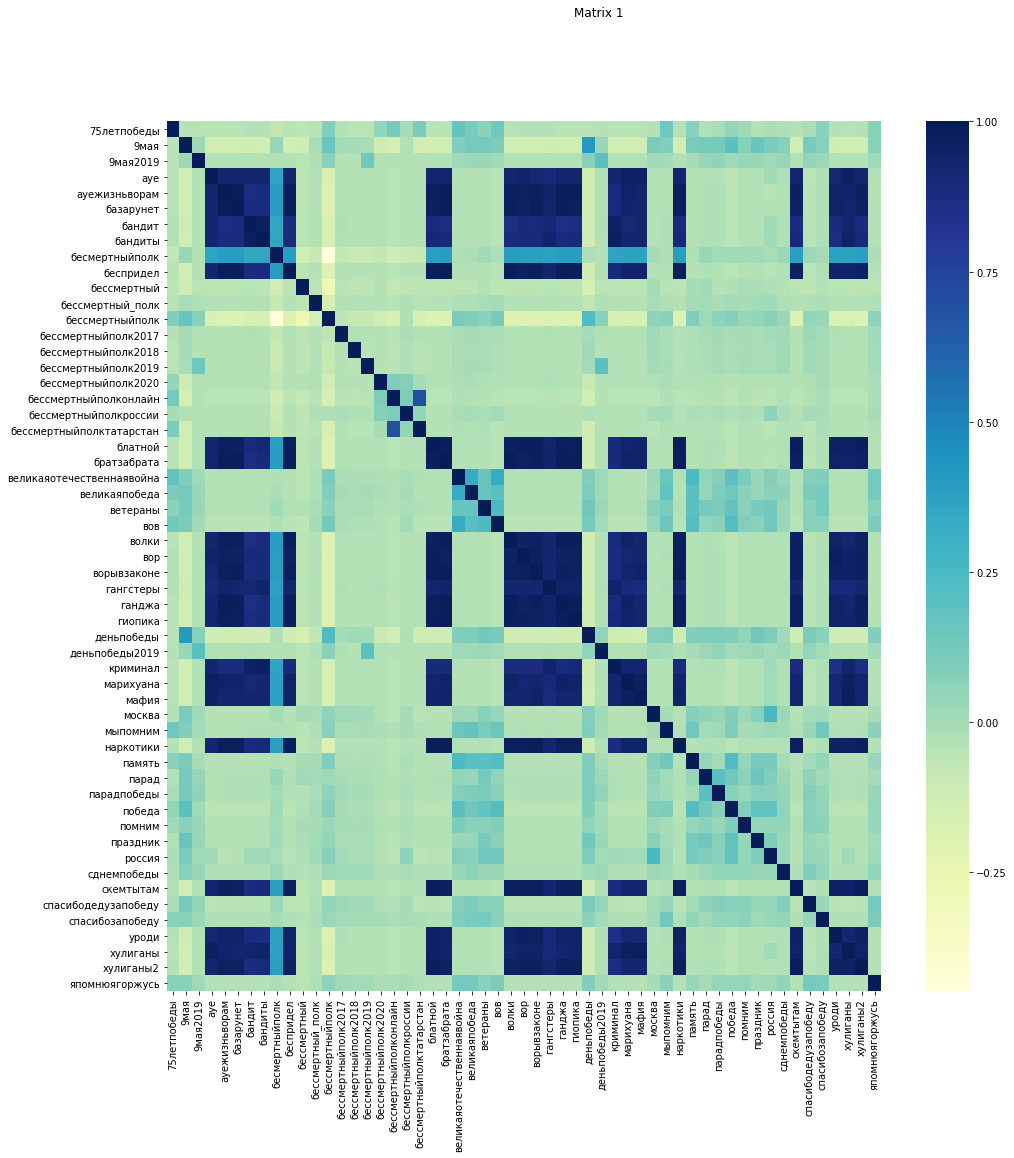

In [25]:
plt.figure(figsize=(l, l))
plt.suptitle('Matrix 1')

sns.heatmap(corr, cmap='YlGnBu')

### Нормализация карты

По тепловой карте Matrix 1 видно, что блатные теги полностью коррелируют сами с собой. А в выборке оказались за счет тегов `#бессмертныйполк` и `#бесмертныйполк` (с одной С).

Посмотрим на эти посты.

In [26]:
df[df.tags.str.join(',').str.contains('ауе')].loc[:, ['post_url', 'tags']].head(10)

,post_url,tags
130,https://www.instagram.com/p/B-sRjt6BE3T/,"[взаимныелайки, взаимныекомментарии, видео, ви..."
409,https://www.instagram.com/p/B-tYmZPhl66/,"[взаимныелайки, взаимныекомментарии, видео, ви..."
535,https://www.instagram.com/p/B-pqWd_BKFE/,"[взаимныелайки, взаимныекомментарии, видео, ви..."
818,https://www.instagram.com/p/B-fhGwwjiTC/,"[криминальнаяроссия, мафия, воровской, бандит,..."
1393,https://www.instagram.com/p/B-IAl66qQOA/,"[криминальнаяроссия, мафия, воровской, бандит,..."
2240,https://www.instagram.com/p/B9pPSkcKumi/,"[криминальнаяроссия, мафия, воровской, бандит,..."
2531,https://www.instagram.com/p/B9bizh6KrMB/,"[криминальнаяроссия, мафия, воровской, бандит,..."
2588,https://www.instagram.com/p/B9Xh_L5Ke4j/,"[криминальнаяроссия, мафия, воровской, бандит,..."
2695,https://www.instagram.com/p/B9SJXChIgxE/,"[криминальнаяроссия, мафия, воровской, бандит,..."
3039,https://www.instagram.com/p/B9BrkYtI1Vy/,"[криминальнаяроссия, мафия, воровской, бандит,..."


Одно из моих личных предположений, такой результат дают специальные приложения, якобы повышающие охват постов засчет использования популярных тегов. Однако если кто-то знает наверняка, поделитесь своим знанием.

В пользу этого может свидетесьтвовать диаграмма распределения количества блатных тегов на один пост: 

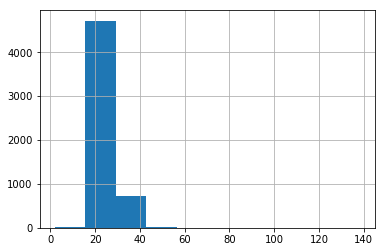

In [27]:
df[df.tags.str.join(',').str.contains('ауе')].tags.str.len().hist()

Как видно, в среднем их используют от 20 до 40 на один пост, а в некоторых случаях доходит и до 60. Скорее всего дело в спецаильных приложениях.

Следующим шагом очистим множество популярных тегов `top_tags_set` от блатных, для этого удалим посты, в которых встречается тег `#ауе`. Однако сделаем этого только для построения тепловой карты, поскольку такой результат интересен и может использоваться для дальнейшего исследования, а именно – сетевого анализа.  

In [28]:
df_filtered = df.drop(df[df.tags.str.join(',').str.contains('бандит')].index); df_filtered.head()

,id,post_url,caption,tags,top_tags
0,2290507756257899980,https://www.instagram.com/p/B_JhKsvB3XM/,#75летпобеды #победа75 #мыпомним #великаяпо...,"[75летпобеды, победа75, мыпомним, великаяпобед...","[75летпобеды, мыпомним, великаяпобеда, бессмер..."
1,2283363816720116246,https://www.instagram.com/p/B-wI0sklSoW/,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный...","[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
2,2283364236083479227,https://www.instagram.com/p/B-wI6zIlkK7/,«Мой дедушка - герой!» #япомнюягоржусь #деньпо...,"[япомнюягоржусь, деньпобеды, 9мая, бессмертный...","[япомнюягоржусь, деньпобеды, 9мая, бессмертный..."
3,2283370574013238191,https://www.instagram.com/p/B-wKXByo4uv/,Вышел в свет новый номер газеты «Каширские изв...,"[каширскоеиа, кашира, подмосковье, вкурсе2020,...",[бессмертныйполк]
4,2283365441896285449,https://www.instagram.com/p/B-wJMWIoYUJ/,Вот что получилось у меня после первых прислан...,"[вокальнаястудиядебют, флешмоб2020, бессмертны...",[бессмертныйполк]


Повторим предыдущие шаги по выделению топовых тегов. Для удобства работы вынесу часть оработки в функции.

In [29]:
def get_top_tags_set(df, min_count):
    
    flattened_tags = pd.Series([tag for tag_list in df.tags for tag in tag_list])
    flattened_tags_counts = flattened_tags.value_counts()
    top_tags_set = set(flattened_tags_counts.loc[flattened_tags_counts > min_count].index)
    
    return top_tags_set

In [30]:
def get_tag_vector_matrix(df, top_tags_set):
    tag_vector_df = df.loc[:, ['top_tags']]

    for tag in sorted(top_tags_set):
        tag_vector_df[f"{tag}"] = tag_vector_df.top_tags.apply(lambda x: bool(tag in x))

    tag_vector_matrix = tag_vector_df.drop(columns=['top_tags'])
    
    return tag_vector_matrix

In [31]:
top_tags_set = get_top_tags_set(df_filtered, 3500); len(top_tags_set)

36

In [32]:
top_tags_set

{'75летпобеды',
 '9мая',
 '9мая2019',
 'russia',
 'victoryday',
 'бесмертныйполк',
 'бессмертный',
 'бессмертный_полк',
 'бессмертныйполк',
 'бессмертныйполк2017',
 'бессмертныйполк2018',
 'бессмертныйполк2019',
 'бессмертныйполк2020',
 'бессмертныйполкдома',
 'бессмертныйполконлайн',
 'бессмертныйполкроссии',
 'бессмертныйполктатарстан',
 'великаяотечественнаявойна',
 'великаяпобеда',
 'ветераны',
 'вов',
 'деньпобеды',
 'деньпобеды2019',
 'москва',
 'мыпомним',
 'память',
 'парад',
 'парадпобеды',
 'победа',
 'помним',
 'праздник',
 'россия',
 'сднемпобеды',
 'спасибодедузапобеду',
 'спасибозапобеду',
 'япомнюягоржусь'}

Как видно, лишь один тег `#ауе` помог полностью избавиться от блатных постов.

In [33]:
df_filtered['top_tags'] = df_filtered.tags.apply(lambda x: [tag for tag in x if tag in top_tags_set])
df_top_tags = df_filtered.loc[df_filtered.top_tags.apply(lambda x: x !=[])]

In [34]:
tag_vector_matrix = get_tag_vector_matrix(df_top_tags, top_tags_set); tag_vector_matrix.head()

,75летпобеды,9мая,9мая2019,russia,victoryday,бесмертныйполк,бессмертный,бессмертный_полк,бессмертныйполк,бессмертныйполк2017,...,парад,парадпобеды,победа,помним,праздник,россия,сднемпобеды,спасибодедузапобеду,спасибозапобеду,япомнюягоржусь
0,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
corr = tag_vector_matrix.corr()

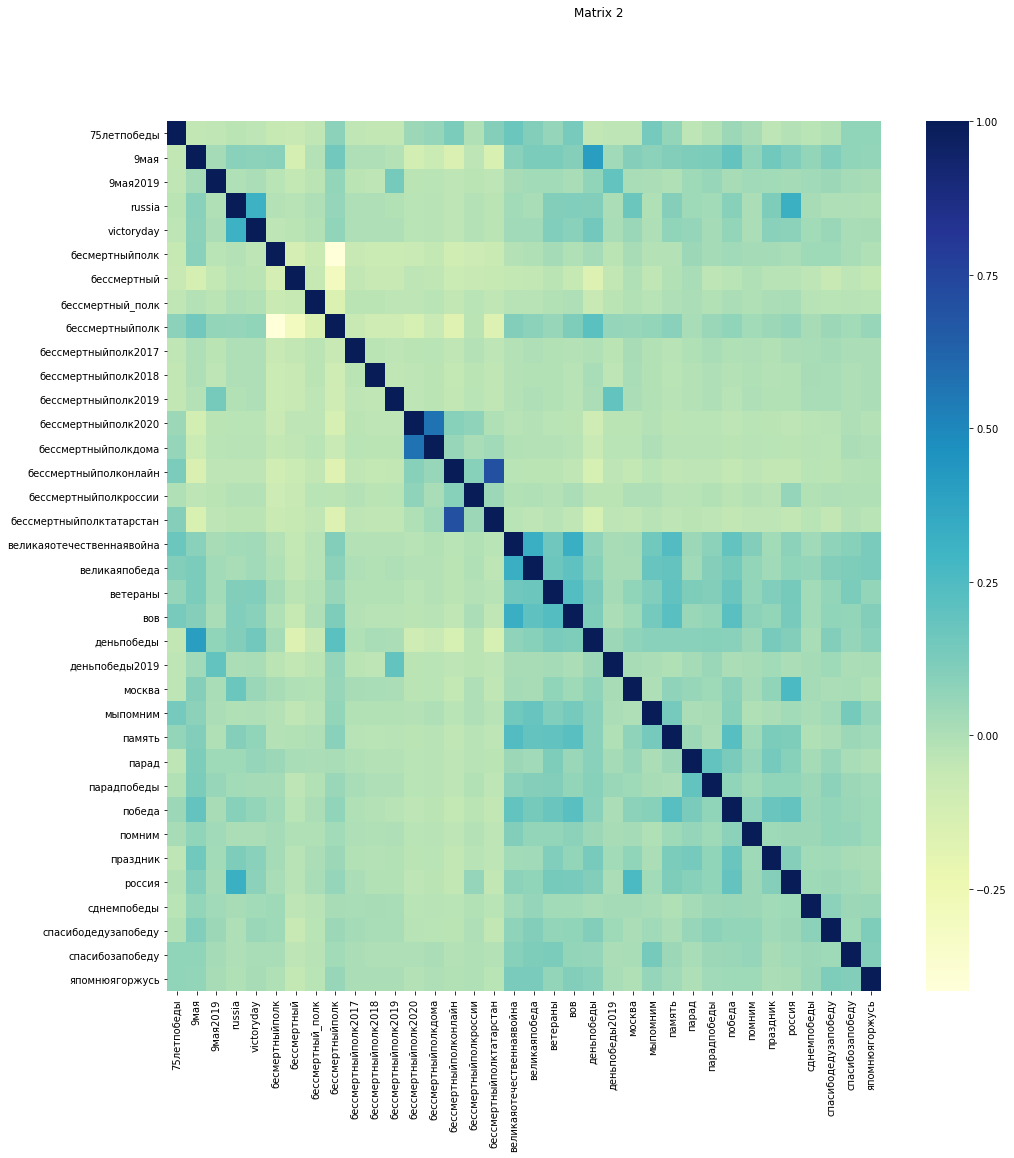

In [36]:
plt.figure(figsize=(l, l))
plt.suptitle('Matrix 2')

sns.heatmap(corr, cmap='YlGnBu')

График Matrix 2 выглядит гораздо интересней. Четко прослеживаются такие зависимости, как:
* `#деньпобеды` и `#9мая`;
* `#victoryday` и `#russia`;
* `#россия` и `#russia`;
* `#бессмертныйполкдома` и `#бессмертныйполк2020` – интересно, почему :));
* `#бессмертныйполктатарстан` и `#бессмертныйполконлайн` – крайне интересно, фактически самая большая корреляция. Наводит на мысль о проведении различных акций на региональном масштабе республики.  